# Emulating DFT with machine learning. 

This notebook developed by Beatriz G. del Rio and Rampi Ramprasad, allows you to use the ML models introduced in the paper to make predictions on polymers containing N and/or O, as well as hydrocarbon molecules.       

First we clone the repository and install all the necessary packages.

In [ ]:
#@title
!git clone https://github.com/Ramprasad-Group/ML-DFT.git
!pip install pymatgen==2019.10.4
!pip install keras==2.2.4
!pip install scikit-learn==0.21.3
!pip uninstall tensorflow -y
!pip install tensorflow-gpu==1.15
!apt install --allow-change-held-packages libcudnn7=7.4.1.5-1+cuda10.0
!pip install h5py==2.10.0
!pip install py3Dmol

# Making predictions on a POSCAR

In this section we will show how to use ML-DFT to predict the electronic structure of a polymer structure in POSCAR format. Just upload your POSCAR file using the icon on the left column (see figure below). 
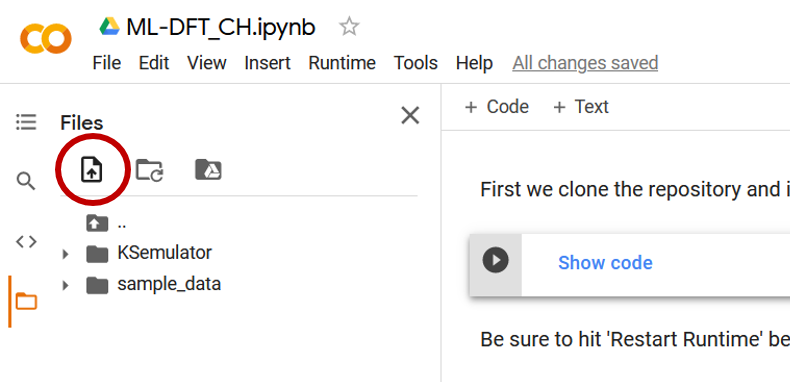

During prediction you will get various files on the left column (which you can download) containing the predicted charge density (CHGCAR), atomic charges for each atom, and DOS curve. The CHGCAR file can be downloaded and directly opened with VESTA.

We load the necessary packages and specific functions required to fingerprint and predict the electron density, potential energy, and DOS. They are located in the src/ folder.

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pymatgen
from pymatgen import io
from pymatgen.io.vasp.outputs import Poscar
from pymatgen.io.cif import CifWriter
from pymatgen import Structure
import time
from keras.preprocessing.sequence import pad_sequences
import pandas as pd
import py3Dmol
import os
import sys
sys.path.insert(0,'/content/ML-DFT/')
#sys.path.insert(1, '../../src/')
from MLDFT.src.FP import fp_atom,fp_chg_norm,fp_norm
from MLDFT.src.CHG import init_chgmod,chg_predict,chg_ref,chg_pred_data,chg_pts,chg_print,chg_dat_prep,coef_predict
from MLDFT.src.Energy import init_Emod,energy_predict
from MLDFT.src.DOS import init_DOSmod,DOS_pred, DOS_plot
from inp_params import test_chg,test_e,test_dos,plot_dos,write_chg,grid_spacing
class Input_parameters:
    test_chg=test_chg
    test_e=test_e
    test_dos=test_dos
    plot_dos=plot_dos
    write_chg=write_chg
    grid_spacing=grid_spacing

inp_args=Input_parameters()
elec_dict={6:4,1:1,7:5,8:6}

Note that in the previous cell we define the dictionary elec_dict which connects the atomic number of each atom with the number of valence electrons it has. Carbon has atomic number 6, and in the POTCAR we used for our reference VASP calculations, the number of valence electrons is 4. Hydrogen, with atomic number 1, only has 1 electron; nitrogen with atomic number 7, has 5 valence electrons; and oxygen with atomic number 8 has 6 valence electrons.

Now we will read the uploaded POSCAR file and show the structure. 

In [ ]:
poscar_data=Poscar.from_file('POSCAR')
d=poscar_data.structure
d.to(filename='Struct.cif')
p = Structure.from_file('Struct.cif')
view=py3Dmol.view()
view.addModel(open('/content/Struct.cif','r').read(),'cif')
view.addUnitCell()
view.zoomTo()
view.setStyle({"stick":{}})
view.show()

Afterwards, we fingerprint each atom in the cell. We call the function fp_atom which only requires the information of the cell and the list of elements with the number of atoms of each element. As output, we obtain the fingerprints set ('dset'), the matri to transform between the internal reference system of each atom and the reference Cartesian system (basis_mat), the position of each atom separated by element type ('sites_elem'), the total number of atoms ('num_atoms'), and the atoms per element ('at_elem').

Afterwards, we prepare the input data for the charge density model.

In [ ]:
vol = poscar_data.structure.volume
supercell = poscar_data.structure
dim=supercell.lattice.matrix
atoms=supercell.num_sites
elems_list = sorted(list(set(poscar_data.site_symbols)))
electrons_list = [elec_dict[x] for x in list(poscar_data.structure.atomic_numbers)]
inp_args.total_elec = sum(electrons_list)
dset,basis_mat,sites_elem,num_atoms,at_elem=fp_atom(poscar_data,supercell,elems_list)
dataset1 = dset[:]
total_elec=inp_args.total_elec
print('Total number of electrons inside cell:',total_elec)
i1=at_elem[0]
i2=at_elem[1]
i3=at_elem[2]
i4=at_elem[3]
num_atoms=np.array(dataset1.shape[0])
dataset_at1=dataset1[0:i1]
basis_at1=basis_mat[0:i1].reshape(i1,9)
dataset_at2=dataset1[i1:i1+i2]
basis_at2=basis_mat[i1:i1+i2].reshape(i2,9)
if i3!= 0:
    dataset_at3=dataset1[i1+i2:i1+i2+i3]
    basis_at3=basis_mat[i1+i2:i1+i2+i3].reshape(i3,9)
else:
    dataset_at3=np.array([0]*360).reshape(1,360)
    basis_at3=np.array(([0]*9)).reshape(1,9)
if i4!=0:
    dataset_at4=dataset1[i1+i2+i3:]
    basis_at4=basis_mat[i1+i2+i3:].reshape(i4,9)
else:
    dataset_at4=np.array(([0]*360)).reshape(1,360)
    basis_at4=np.array(([0]*9)).reshape(1,9)

del dataset1,basis_mat
padding_size=max([i1,i2,i3,i4])
X_tot_at1=pad_sequences(dataset_at1.T,maxlen=padding_size,dtype='float32',padding='post',value=0.0)
base_at1=pad_sequences(basis_at1.T,maxlen=padding_size,dtype='float32',padding='post',value=0.0)
X_tot_at2=pad_sequences(dataset_at2.T,maxlen=padding_size,dtype='float32',padding='post',value=0.0)
base_at2=pad_sequences(basis_at2.T,maxlen=padding_size,dtype='float32',padding='post',value=0.0)
X_tot_at3=pad_sequences(dataset_at3.T,maxlen=padding_size,dtype='float32',padding='post',value=0.0)
base_at3=pad_sequences(basis_at3.T,maxlen=padding_size,dtype='float32',padding='post',value=0.0)
X_tot_at4=pad_sequences(dataset_at4.T,maxlen=padding_size,dtype='float32',padding='post',value=0.0)
base_at4=pad_sequences(basis_at4.T,maxlen=padding_size,dtype='float32',padding='post',value=0.0)
X_3D1=np.reshape(X_tot_at1.T,(1,padding_size,dataset_at1.shape[1]))
basis1=np.reshape(base_at1.T,(1,padding_size,9))
X_3D2=np.reshape(X_tot_at2.T,(1,padding_size,dataset_at2.shape[1]))
basis2=np.reshape(base_at2.T,(1,padding_size,9))
X_3D3=np.reshape(X_tot_at3.T,(1,padding_size,dataset_at3.shape[1]))
basis3=np.reshape(base_at3.T,(1,padding_size,9))
X_3D4=np.reshape(X_tot_at4.T,(1,padding_size,dataset_at4.shape[1]))
basis4=np.reshape(base_at4.T,(1,padding_size,9))

Once the fingerprint tensors are padded, the chg_predict funtion predicts the valence electron density components and atomic charge for each atom.
We can print out the valence electrons associated with each atom. For C, N, and O, being more electronegative than H, they will tend to have values slightly higher than 4, 5 and 6, respectively. H atoms will always have values lower than 1. For future use, these values are printed out on text files.

In [ ]:
modelCHG=init_chgmod(padding_size)
Coef_at1,Coef_at2,Coef_at3, Coef_at4,C_at_charge, H_at_charge, N_at_charge, O_at_charge=chg_predict(X_3D1,X_3D2,X_3D3,X_3D4,i1,i2,i3,i4,sites_elem,modelCHG,at_elem)

print('Atomic charges for the C atoms (same order as in POSCAR):', C_at_charge)
print('Atomic charges for the H atoms (same order as in POSCAR):', H_at_charge)
if i3!= 0:
    print('Atomic charges for the N atoms (same order as in POSCAR):', N_at_charge)
if i4!=0:
    print('Atomic charges for the O atoms (same order as in POSCAR):', O_at_charge)
localfile_loc = "Predicted"
print("Writing atomic charges to files...")
np.savetxt("C_charges" + localfile_loc + ".txt",np.c_[C_at_charge])
np.savetxt("H_charges" + localfile_loc + ".txt",np.c_[H_at_charge])
if i3!= 0:
    np.savetxt("N_charges" + localfile_loc + ".txt",np.c_[N_at_charge])
if i4!=0:
    np.savetxt("O_charges" + localfile_loc + ".txt",np.c_[O_at_charge])

One tool provided with the ML-DFT package is printing out the predicted valence electron density projected onto grid points. There are two options to use this tool:

1) By simply selecting a grid spacing (in inp_params.py), the code will calculate and identify the coordinates of the corresponding grid points from the cell structure and use the predicted components of the electron density to project it onto them.

2) If a reference CHGCAR file already exists and the user desires to make a prediction to compare with it, then it needs to write ref_chg=True in inp_params.py, and the code will automatically search for the CHGCAR, read the grid points and coordinates and project onto them the predicted electron density.

In both cases, the projected electron density is written in the same format as CHGCAR from VASP, to be further used in visualization tools such as *VESTA* or other postprocessing tools such as *critic2* to study the non-covalent interactions, for example. To be read by *VESTA*, the name of the file needs to be changed to 'CHGCAR'.

In this notebook, you can choose the grid spacing you desire for the projection in the tag **'grid_spacing'** in the next cell. 

IMPORTANT!!: Projecting the predicted electron density onto grid points is a time consuming process (the most time consuming of all). As it is not required for the ML-DFT to make predictions, only for further postprocessing, we advice the user to use this tool with caution.

Projection of the predicted charge density is not necessary to predict the potential energy or DOS, and therefore, larger grid spacing will have no effect on the subsequent predictions. It is just a visualization tool.

In [ ]:
import shutil
print("Writing predicted charge density to file...")
Poscar(p).write_file('POSCAR_c')
shutil.move('POSCAR_c', "Pred_CHG_test"+ localfile_loc +".dat")
grid_spacing=0.6
chg_coor,num_pts=chg_pts(poscar_data, supercell,grid_spacing)
Pred_chg=chg_pred_data(poscar_data,at_elem,sites_elem,Coef_at1,Coef_at2,Coef_at3,Coef_at4,chg_coor,dim,vol)
chg_print(Pred_chg,vol,localfile_loc,num_pts)
!mv Pred_CHG_testPredicted.dat CHGCAR

Once projected and written out, the charge density can be visualized using a desired isosurface value, which you can also modify in this notebook in the tag **'isosurf_val'** in the next cell.

In [ ]:
!chmod 755 /content/ML-DFT/chg2cube.pl
!/content/ML-DFT/chg2cube.pl CHGCAR
view2=py3Dmol.view()
isosurf_val=0.0015
view2.addVolumetricData(open('/content/CHGCAR.cube','r').read(),"cube",{'isoval': isosurf_val, 'color': "yellow", 'opacity': 0.70})
view2.addModel(open('/content/Struct.cif','r').read(),'cif')
view2.addUnitCell()
view2.zoomTo()
view2.setStyle({"stick":{}})
view2.show()

As described in the paper, once the electron density components are predicted, they are used, along with the fingerprints, as input for the prediction of the total potential energy, forces, stress tensor and DOS. The fp_chg_norm function simply concatenates these components to the fingerprints for each atom and normalizes them.

Then, the energy_predict function predicts the atomic potential energy for each atom and sums it all. It also predicts the forces for each atom in the POSCAR file as well as the idependent components of the stress tensor (Sxx, Syy, Szz, Sxy, Syz, Sxz) in kB.


In [ ]:
X_C,X_H,X_N,X_O=fp_chg_norm(Coef_at1,Coef_at2,Coef_at3,Coef_at4,X_3D1,X_3D2,X_3D3,X_3D4,padding_size)
modelE=init_Emod(padding_size)
Pred_Energy,ForC,ForH,ForN,ForO,Stress=energy_predict(X_C,X_H,X_N,X_O,basis1,basis2,basis3,basis4,num_atoms.reshape(1,1),modelE)
print('Total potential energy:', Pred_Energy, 'eV')
Forces=np.concatenate((ForC[0:i1],ForH[0:i2]),axis=0)
if i3!= 0:
    Forces=np.concatenate((Forces,ForN[0:i3]),axis=0)
if i4!= 0:
    Forces=np.concatenate((Forces,ForO[0:i4]),axis=0)
print('Atomic forces (in eV/A):', Forces)
print('The stress tensor components are (in kB): Sxx:', Stress[0],' Syy:', Stress[1],' Szz:', Stress[2], ' Sxy:', Stress[3],' Syz:', Stress[4],' Sxz:', Stress[5] )

Finally, the DOS is also predicted by using the same input as the total potential energy model. The predicted DOS curve is printed out in a txt file.

Additionally, the code already provides the option to make a png image of the DOS curve with the uncertainty and valence and conduction bands. To activate this option when running in command line, make plot_dos=True in inp_params.py. In this notebook example, we directly plot it.

In [ ]:
modelD=init_DOSmod(padding_size)
total_elec=inp_args.total_elec
Pred, uncertainty,VB,devVB,CB,devCB,BG,devBG=DOS_pred(X_C,X_H,X_N,X_O,np.array(total_elec).reshape(1,1),modelD)
DOS=np.squeeze(Pred)
print('Valence band:', VB, '+-', devVB, 'eV')
print('Conduction band:', CB, '+-', devCB, 'eV')
print('Bandgap:', BG, '+-', devBG, 'eV')
energy_wind=np.arange(-33.0,1.1,0.1)
print("Writing DOS curve to file...")
np.savetxt("DOS" + localfile_loc +".txt",np.c_[energy_wind,DOS])

DOS_plot(energy_wind,DOS,VB,CB,uncertainty, localfile_loc)
!mv dos_Predicted\ .png DOS.png

from IPython.display import Image
fig = Image(filename=("DOS.png"), width=600)
fig

The predicted DOS curve is shown in red, with a grey shadowed area identifying the uncertainty in the prediction. As explained in the manuscript, the valence band maximum and conduction band minimum do not fall on the zero value of DOS, because they are trained by using as reference the actual eigenvalues, to avoid the effect of the gaussian smearing used to smooth the DOS curve. All values are given with respect to the vacuum level (0 eV).